In [1]:
from expansion_tools.blob_expansion_tools_jetset import *
from expansion_tools.delay_analysis import gamma_radio_delay_analysis_vs_freq,plot_lcs,gamma_radio_delay_analysis_vs_v_exp,plot_lcs_single_panel
from jetset.data_loader import Data,ObsData
from jetset.plot_sedfit import PlotSED


## Notebook to reproduce Section 4 of the paper

In [2]:
sed_data = ObsData(data_table=Data.from_file('sed_mrk421_mjd_56302.ecsv'))
from jetset.model_manager import  FitModel
fit_model=FitModel.load_model('processing/fit_model_lsb_mjd56302.pkl')

In [3]:
rest_frame='obs'
delta_t_out=1E3
t_exp=1E7

## expansion short

In [4]:
from jetset.jet_timedep import JetTimeEvol
temp_ev_acc_flare=JetTimeEvol.load_model('temp_ev_sim_flare/temp_ev_acc_flare.pkl')
R0=temp_ev_acc_flare.rad_region.jet.parameters.R.val

def delta_t_est(t_exp,R0,beta_exp):
    return t_exp+R0/(beta_exp*3E10)

def t_dec_est(R0,a,beta_exp):
    return ((R0+beta_exp*3E10)*np.power(beta_exp*3E10,a))




In [5]:
def updage_fig(fig):
    for ax in fig.axes:
        try:
            ax.ticklabel_format(axis='y', style='sci')
            ax.yaxis.major.formatter._useMathText = True
        except:
            print('ticklabel_format failed')
            pass
        
        ax.legend( loc='best', ncol=1,fontsize=15)
        ax.xaxis.label.set_size(15)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.label.set_size(15)
        ax.yaxis.set_tick_params(labelsize=15)

In [6]:
def update_sed_plot(p):
    p.sedplot.legend(bbox_to_anchor=(1, 1), loc='best', ncol=1,fontsize=15)
    p.sedplot.xaxis.label.set_size(15)
    p.sedplot.xaxis.set_tick_params(labelsize=15)

    p.secaxy.xaxis.label.set_size(15)
    p.secaxy.xaxis.set_tick_params(labelsize=15)

    p.sedplot.yaxis.label.set_size(15)
    p.sedplot.yaxis.set_tick_params(labelsize=15)
    p.fig.tight_layout()

In [7]:
def update_lc_plot(fig):
    for ax in fig.axes:
        ax.ticklabel_format(axis='y', style='sci')
        ax.yaxis.major.formatter._useMathText = True
        
        ax.legend( loc='best', ncol=1,fontsize=15)
        ax.xaxis.label.set_size(15)
        ax.xaxis.set_tick_params(labelsize=15)
        ax.yaxis.label.set_size(15)
        ax.yaxis.set_tick_params(labelsize=15)
        
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)
    fig.tight_layout()

Set `run=False` if you have already run the simulations, and you want only to regenerate lcs or SEDs

In [8]:

beta_exp=[0.1]
run=True
t_exp=1E7


for ID,v in enumerate(beta_exp):
    duration=delta_t_est(t_exp,R0,v)+10*t_dec_est(R0,-1,v)
    T_SIZE=np.int(duration/1000)
    NUM_SET=np.int(T_SIZE)
    NUM_SET=min(5000,NUM_SET)
    NUM_SET=max(200,NUM_SET)
    print('ID',ID)
    print('beta_exp %f'%v)
    print('delta_t  est. %e (d)'%(delta_t_est(t_exp,R0,v)/86400))
    print('t_dec  est. %e (d)'%(t_dec_est(R0,-1,v)/86400))
    print('delay  est. %e (s)'%(delta_t_est(t_exp,R0,v)))
    print('t_dec  est. %e (s)'%(t_dec_est(R0,-1,v)))
    print('duration %e'%duration)
    print('T_SIZE %d'%T_SIZE)
    print('NUM_SET %d'%NUM_SET)
    run_adiabatic_exp(None,
                      fit_model,
                      'temp_ev_sim_exp_vs_no_exp',
                      temp_ev_acc_flare,
                      flare_duration=0,
                      average=None,
                      duration=duration,
                      delta_t_out=delta_t_out,
                      T_esc_rad=1E60,
                      rest_frame=rest_frame,
                      T_SIZE=T_SIZE,
                      NUM_SET=NUM_SET,
                      run=run,
                      beta_exp=v,
                      t_exp=t_exp)
    
   
    print('----------------------------------------------')

ID 0
beta_exp 0.100000
delta_t  est. 1.350309e+02 (d)
t_dec  est. 1.929014e+01 (d)
delay  est. 1.166667e+07 (s)
t_dec  est. 1.666668e+06 (s)
duration 2.833334e+07
T_SIZE 28333
NUM_SET 5000
==> par: z_cosm from model: jet_leptonicacc_region linked to same parameter in model jet_leptonic
temporal evolution running


  0%|          | 0/28333 [00:00<?, ?it/s]

temporal evolution completed
caching SED for each saved distribution: start


  0%|          | 0/5000 [00:00<?, ?it/s]

caching SED for each saved distribution: done
10000000.0 10000000.0 28333343.33333333
t1=1764 t2=000, t2_R=0.000e+00, R2=5.00000e+15 t/t_ref=0.000 t/t_exp=0.000 t/duration=0.000 1.00158e+00
t1=1764 t2=555, t2_R=3.151e+06, R2=5.00000e+15 t/t_ref=0.315 t/t_exp=0.315 t/duration=0.111 1.00158e+00
t1=1764 t2=1111, t2_R=6.302e+06, R2=5.00000e+15 t/t_ref=0.630 t/t_exp=0.630 t/duration=0.222 1.00158e+00
t1=1764 t2=1666, t2_R=9.447e+06, R2=5.00000e+15 t/t_ref=0.944 t/t_exp=0.944 t/duration=0.333 1.00158e+00
t1=1764 t2=2222, t2_R=1.260e+07, R2=1.27861e+16 t/t_ref=1.259 t/t_exp=1.259 t/duration=0.445 1.00219e+00
t1=1764 t2=2777, t2_R=1.574e+07, R2=2.22147e+16 t/t_ref=1.574 t/t_exp=1.574 t/duration=0.556 1.00269e+00
t1=1764 t2=3333, t2_R=1.889e+07, R2=3.16612e+16 t/t_ref=1.889 t/t_exp=1.889 t/duration=0.667 9.99916e-01
t1=1764 t2=3888, t2_R=2.204e+07, R2=4.10898e+16 t/t_ref=2.204 t/t_exp=2.204 t/duration=0.778 9.76348e-01
t1=1764 t2=4444, t2_R=2.519e+07, R2=5.05364e+16 t/t_ref=2.519 t/t_exp=2.519 

In [9]:
temp_ev_expansion=JetTimeEvol.load_model('temp_ev_sim_exp_vs_no_exp/temp_ev_expansion_beta_exp=0.100.pkl')
temp_ev_acc_flare=JetTimeEvol.load_model('temp_ev_sim_flare/temp_ev_acc_flare.pkl')

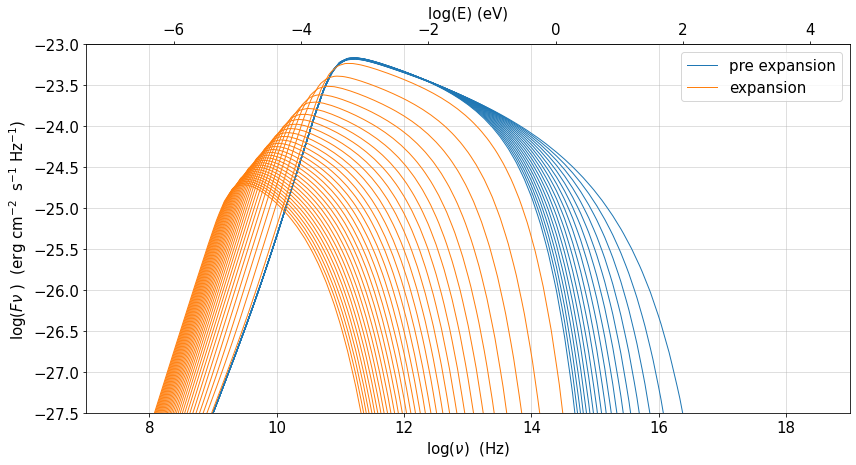

In [10]:
%matplotlib inline
p=PlotSED(frame='obs',density=True)
p.resplot.remove()
skip_label=False
step=int(NUM_SET/50)

for i in range(0,NUM_SET,step):
    
    t=temp_ev_expansion.rad_region.time_sampled_emitters._get_time_samples(time_slice=i)
    s=temp_ev_expansion.rad_region.get_SED(comp='Sync',time_slice=i,frame='obs',use_cached=True)
    if t[0][0]<temp_ev_expansion.parameters.t_jet_exp.val:
        c='C0'
    else:
        c='C1'
    label=None
    if i==0:
        label='pre expansion'
    #print(t[0][0],temp_ev_expansion.parameters.t_jet_exp.val)
    if t[0][0]>=temp_ev_expansion.parameters.t_jet_exp.val and skip_label is False:
        label='expansion'
        skip_label=True
    p.add_model_plot(model=s,label=label,color=c,density=True,auto_label=False)
p.rescale(y_min=-27.5,y_max=-23,x_min=7,x_max=19)
update_sed_plot(p)

p.fig.savefig('temp_ev_sim_exp_vs_no_exp/Fnu_beta_exp_0.1.pdf',bbox_inches = 'tight',
    pad_inches = 0)


In [11]:
p.fig.savefig('temp_ev_sim_exp_vs_no_exp/Fnu_beta_exp_0.1.pdf',bbox_inches = 'tight',
    pad_inches = 0)


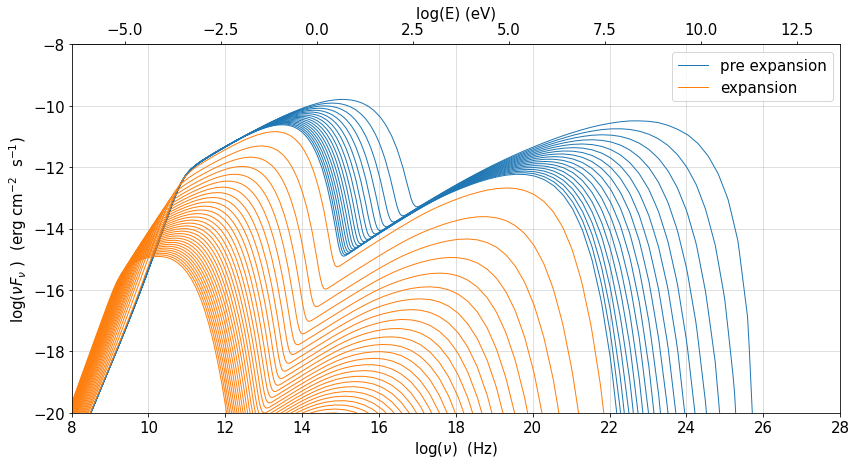

In [12]:
p=PlotSED(frame='obs',density=False)
p.resplot.remove()
skip_label=False

step=int(NUM_SET/50)

for i in  range(0,NUM_SET,step):
    t=temp_ev_expansion.rad_region.time_sampled_emitters._get_time_samples(time_slice=i)
    s=temp_ev_expansion.rad_region.get_SED(comp='Sum',time_slice=i,frame='obs',use_cached=True)
    s_sync=temp_ev_expansion.rad_region.get_SED(comp='Sync',time_slice=i,frame='obs',use_cached=True)
    s_IC=temp_ev_expansion.rad_region.get_SED(comp='SSC',time_slice=i,frame='obs',use_cached=True)

    if t[0][0]<temp_ev_expansion.parameters.t_jet_exp.val:
        c='C0'
    else:
        c='C1'
    label=None
    if i==0:
        label='pre expansion'
    #print(t[0][0],temp_ev_expansion.parameters.t_jet_exp.val)
    if t[0][0]>=temp_ev_expansion.parameters.t_jet_exp.val and skip_label is False:
        label='expansion'
        skip_label=True
    p.add_model_plot(model=s,label=label,color=c,density=False,auto_label=False)

p.rescale(y_min=-20,y_max=-8,x_min=8,x_max=28)

update_sed_plot(p)
p.fig.savefig('temp_ev_sim_exp_vs_no_exp/nuFnu_beta_exp_0.1.pdf',bbox_inches = 'tight',
    pad_inches = 0)


In [13]:
temp_ev_acc_flare=JetTimeEvol.load_model('temp_ev_sim_flare/temp_ev_acc_flare.pkl')

t_flare=temp_ev_acc_flare.parameters.duration.val


In [14]:
import pickle
with open('temp_ev_sim_exp_vs_no_exp/lc_obs_beta_exp=0.100.pkl', 'rb') as f:
    l=pickle.load(f)
l.keys()


dict_keys(['lg_obs', 'lr_obs_5GHz', 'lr_obs_10GHz', 'lr_obs_15GHz', 'lr_obs_20GHz', 'lr_obs_25GHz', 'lr_obs_30GHz', 'lr_obs_35GHz', 'lr_obs_40GHz', 'lr_obs_45GHz', 'lr_obs_50GHz', 'lr_obs_55GHz', 'lr_obs_60GHz', 'lr_obs_65GHz', 'lr_obs_70GHz', 'lr_obs_75GHz', 'lr_obs_80GHz', 'lr_obs_85GHz', 'lr_obs_90GHz', 'lr_obs_95GHz', 'lr_obs_100GHz', 'lr_obs_105GHz', 'lr_obs_110GHz', 'lr_obs_115GHz', 'lr_obs_120GHz', 'lopt_obs', 'lmm_obs', 'lx_obs', 'beta_exp'])

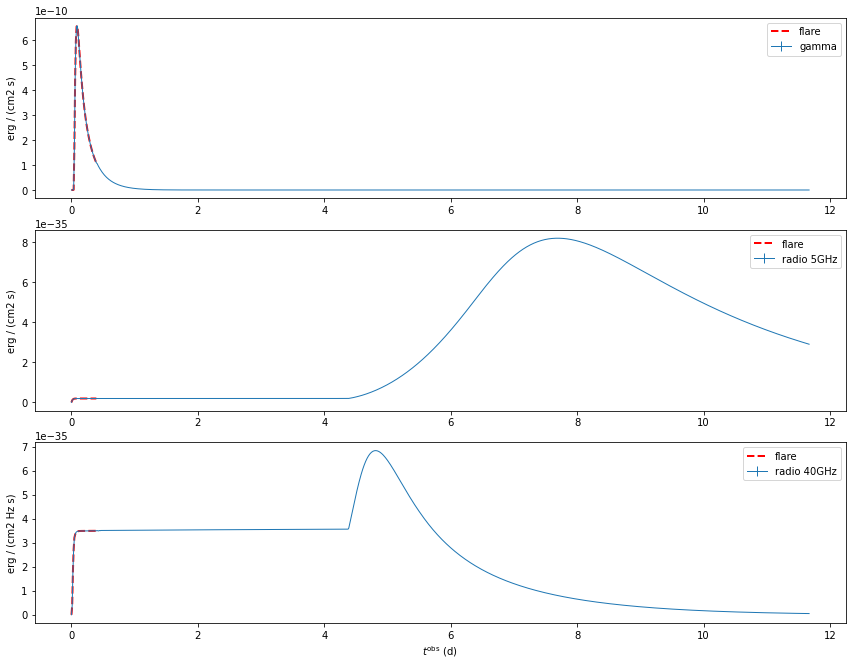

In [15]:
fig=plot_lcs(exp_lcs='temp_ev_sim_exp_vs_no_exp/lc_obs_beta_exp=0.100.pkl',lcs_names=['lg_obs','lr_obs_5GHz','lr_obs_40GHz'],flare_lcs='temp_ev_sim_flare/lc_obs_flare.pkl')

In [16]:
t_flare=temp_ev_acc_flare.parameters.duration.val
t_exp_obs_merged_lcs=(t_flare+t_exp*1.03)/temp_ev_expansion.rad_region.jet.parameters.beam_obj.val/86400

Text(12.190625000000011, 0.5, 'erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$')

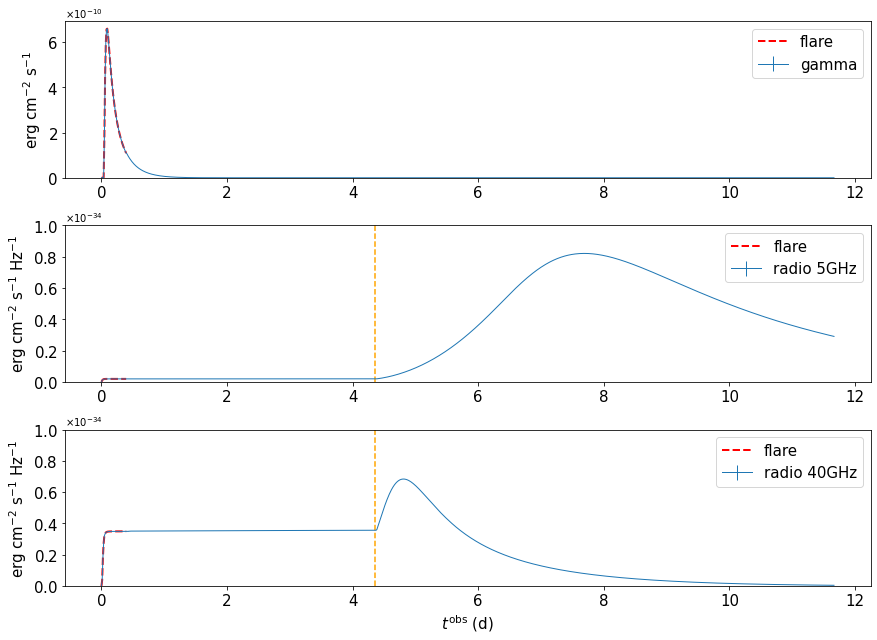

In [17]:
update_lc_plot(fig)
fig.axes[1].axvline(x=t_exp_obs_merged_lcs,ls='--',c='orange')
fig.axes[2].axvline(x=t_exp_obs_merged_lcs,ls='--',c='orange')
fig.axes[0].set_ylim(0,None)
fig.axes[1].set_ylim(0,1E-34)
fig.axes[2].set_ylim(0,1E-34)
fig.axes[0].set_ylabel(r'erg cm$^{-2}$ s$^{-1}$')
fig.axes[1].set_ylabel(r'erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$')
fig.axes[2].set_ylabel(r'erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$')

In [18]:
fig.savefig('temp_ev_sim_exp_vs_no_exp/lc_beta_exp_0.1.pdf',bbox_inches = 'tight',
    pad_inches = 0)

In [19]:
beta_exp=[0.0]


for ID,v in enumerate(beta_exp):
    duration=delta_t_est(t_exp,R0,0.1)+10*t_dec_est(R0,-1,0.1)
    T_SIZE=np.int(duration/1000)
    NUM_SET=np.int(T_SIZE)
    NUM_SET=min(5000,NUM_SET)
    NUM_SET=max(200,NUM_SET)
    print('ID',ID)
    print('beta_exp %f'%v)
    print('delta_t  est. %e (d)'%(delta_t_est(t_exp,R0,0.1)/86400))
    print('T_SIZE %d'%T_SIZE)
    print('NUM_SET %d'%NUM_SET)
    run_adiabatic_exp(sed_data,
                      fit_model,
                      'temp_ev_sim_exp_vs_no_exp',
                      temp_ev_acc_flare,
                      expansion='off',
                      flare_duration=0,
                      average=None,
                      duration=2.833334e+07,
                      delta_t_out=delta_t_out,
                      T_esc_rad=1E60,
                      rest_frame=rest_frame,
                      T_SIZE=T_SIZE,
                      NUM_SET=NUM_SET,
                      run=run,
                      beta_exp=v,
                      t_exp=1E60)
    
   
    print('----------------------------------------------')

ID 0
beta_exp 0.000000
delta_t  est. 1.350309e+02 (d)
T_SIZE 28333
NUM_SET 5000
==> par: z_cosm from model: jet_leptonicacc_region linked to same parameter in model jet_leptonic
temporal evolution running


  0%|          | 0/28333 [00:00<?, ?it/s]

temporal evolution completed
caching SED for each saved distribution: start


  0%|          | 0/5000 [00:00<?, ?it/s]

caching SED for each saved distribution: done
----------------------------------------------


In [20]:
temp_ev_no_expansion=JetTimeEvol.load_model('temp_ev_sim_exp_vs_no_exp/temp_ev_expansion_beta_exp=0.000.pkl')


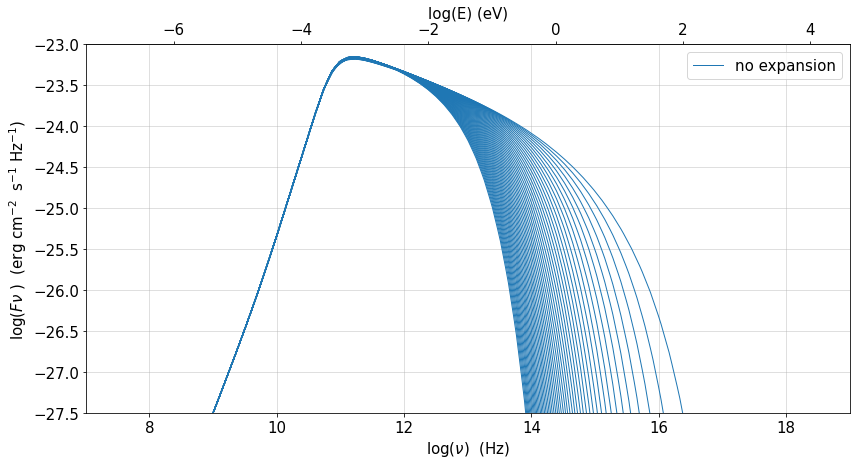

In [21]:
p=PlotSED(frame='obs',density=True)
skip_label=False
p.resplot.remove()
step=int(NUM_SET/50)

for i in range(0,NUM_SET,step):
    t=temp_ev_no_expansion.rad_region.time_sampled_emitters._get_time_samples(time_slice=i)
    s=temp_ev_no_expansion.rad_region.get_SED(comp='Sync',time_slice=i,frame='obs',use_cached=True)
    c='C0'
  
    label=None
    if i==0:
        label='no expansion'
    
    p.add_model_plot(model=s,label=label,color=c,density=True,auto_label=False)
      
p.rescale(y_min=-27.5,y_max=-23,x_min=7,x_max=19)
update_sed_plot(p)

p.fig.savefig('temp_ev_sim_exp_vs_no_exp/Fnu_beta_exp_0.0.pdf',bbox_inches = 'tight',
    pad_inches = 0) 

In [22]:
def get_p_index(temp_ev,time_obs_seconds,log_gmin,log_gmax,plot=False,):
    temp_ev.set_time(time=time_obs_seconds,frame='obs')
    temp_ev.rad_region.jet.emitters_distribution.n_gamma_e
    fig=plt.figure(dpi=100)
    
    y,x= temp_ev.rad_region.jet.emitters_distribution.n_gamma_e,temp_ev.rad_region.jet.emitters_distribution.gamma_e
    msk=np.logical_and(y>0,x>0)
    y=y[msk]
    x=x[msk]
    
    x,y=np.log10([x,y])
   
    
    if plot is True:
        plt.plot(x,y)
        plt.xlim(-1,5)
        plt.ylim(-20,5)
    
    msk=np.logical_and(x>log_gmin,x<log_gmax)
    x1=x[msk]
    y1=y[msk]

    p1 = np.polyfit(x1, y1, 1)
    if plot is True:
        plt.plot(x1,np.poly1d(p1)(x1))
    
    print('p=',p1)
    return p1[0]

In [23]:
def get_nu_SSA(p,nu_max):
    tau_max=(2/5)*p**(1/3)*np.log(p)
    alpha=-(p-1)*0.5
    c=tau_max**(1/(alpha-5/2))
    return nu_max/c


estimate of $\nu_{SSA}^0$

p= [-1.4656453   2.23915488]
nu_max 173.9726432343799
nu_SSA 91.6870232792463


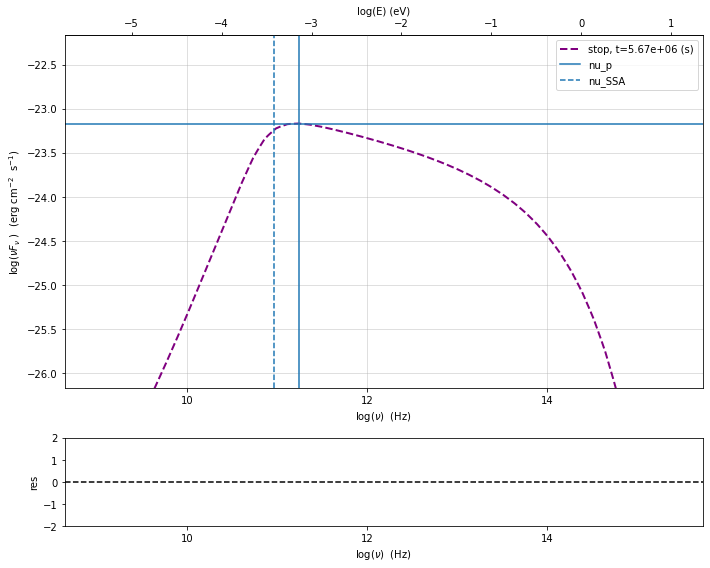

<Figure size 600x400 with 0 Axes>

In [24]:
%matplotlib inline
t=temp_ev_no_expansion.rad_region.time_sampled_emitters._get_time_samples(time_slice=999)
p=temp_ev_no_expansion.plot_tempev_model(density=True,time_slice=999)
s=temp_ev_no_expansion.rad_region.get_SED(comp='Sync',time_slice=999,frame='obs',use_cached=True)
ID=np.argmax(s.nuFnu.value/s.nu.value)
nu_p=s.nu.value[ID]

p.sedplot.axhline(np.log10((s.nuFnu.value/s.nu.value).max()))

p_e=-get_p_index(temp_ev_no_expansion,134,1,3,plot=False)
nu_SSA=get_nu_SSA(p_e,nu_p)

p.sedplot.axvline(np.log10(nu_p),label='nu_p')
p.sedplot.axvline(np.log10(nu_SSA),label='nu_SSA',ls='--')
p.sedplot.legend()
print('nu_max',nu_p/1E9)
print('nu_SSA',nu_SSA/1E9)


In [25]:
fit_model.parameters

model name,name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
jet_leptonic,gmin,low-energy-cut-off,lorentz-factor*,1.586653e+01,1.000000e+00,1.000000e+09,False,False
jet_leptonic,gmax,high-energy-cut-off,lorentz-factor*,5.181316e+05,1.000000e+00,1.000000e+15,False,False
jet_leptonic,N,emitters_density,1 / cm3,1.308777e+02,0.000000e+00,--,False,False
jet_leptonic,gamma0_log_parab,turn-over-energy,lorentz-factor*,3.573558e+03,1.000000e+00,1.000000e+09,False,False
jet_leptonic,s,LE_spectral_slope,,1.708731e+00,-1.000000e+01,1.000000e+01,False,False
jet_leptonic,r,spectral_curvature,,1.074723e+00,-1.500000e+01,1.500000e+01,False,False
jet_leptonic,R,region_size,cm,2.821653e+15,1.000000e+03,1.000000e+30,False,False
jet_leptonic,R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
jet_leptonic,B,magnetic_field,gauss,2.000000e-01,0.000000e+00,--,False,False
jet_leptonic,beam_obj,beaming,lorentz-factor*,4.997505e+01,1.000000e-04,--,False,False


None

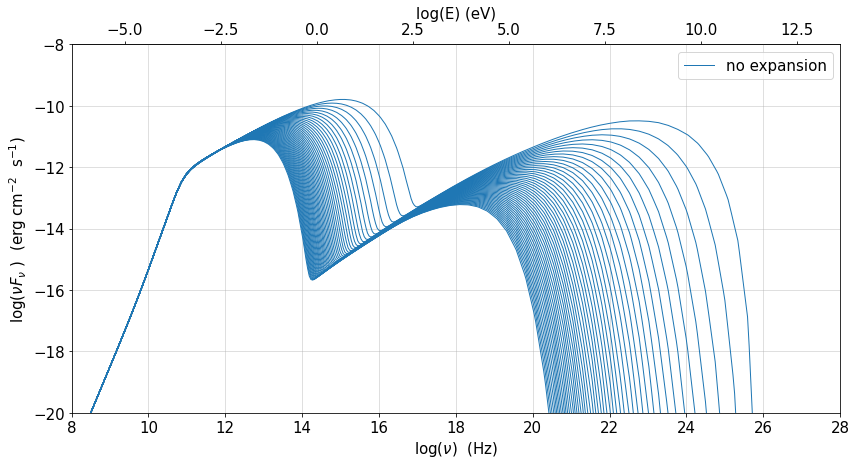

In [26]:
%matplotlib inline
p=PlotSED(frame='obs',density=False)
skip_label=False
p.resplot.remove()

step=int(NUM_SET/50)

for ID,i in enumerate(range(0,NUM_SET,step)):
    t=temp_ev_no_expansion.rad_region.time_sampled_emitters._get_time_samples(time_slice=i)
    s=temp_ev_no_expansion.rad_region.get_SED(comp='Sum',time_slice=i,frame='obs',use_cached=True)
    s_sync=temp_ev_no_expansion.rad_region.get_SED(comp='Sync',time_slice=i,frame='obs',use_cached=True)
    s_IC=temp_ev_no_expansion.rad_region.get_SED(comp='SSC',time_slice=i,frame='obs',use_cached=True)
   
    c='C0'
    #else:
    #    c='g'
    label=None
    if i==0:
        label='no expansion'
    
    p.add_model_plot(model=s,label=label,color=c,density=False,auto_label=False)
      
p.rescale(y_min=-20,y_max=-8,x_min=8,x_max=28)
update_sed_plot(p)

p.fig.savefig('temp_ev_sim_exp_vs_no_exp/nuFnu_beta_exp_0.0.pdf',bbox_inches = 'tight',
    pad_inches = 0) 

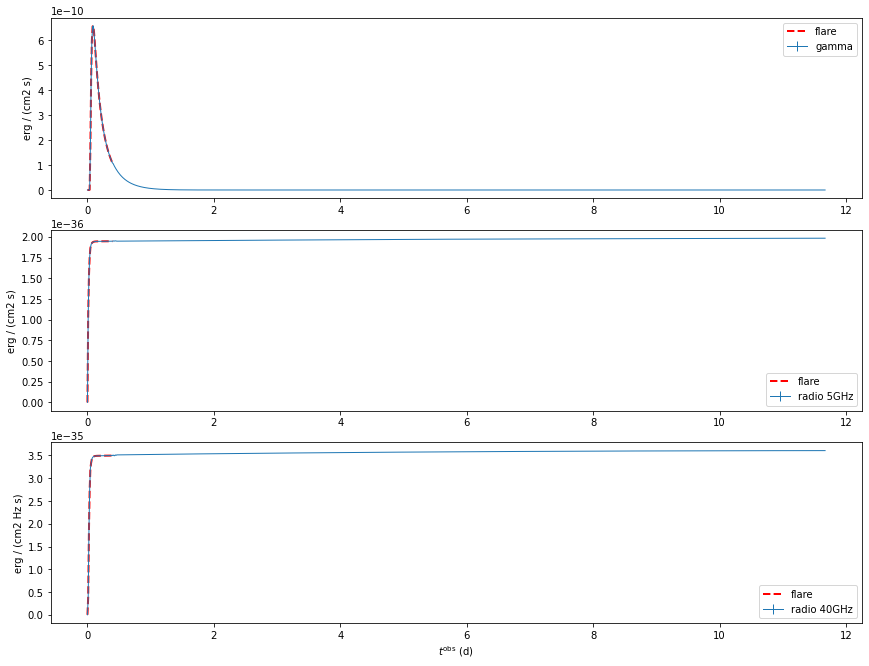

In [27]:
fig=plot_lcs(exp_lcs='temp_ev_sim_exp_vs_no_exp/lc_obs_beta_exp=0.000.pkl',lcs_names=['lg_obs','lr_obs_5GHz','lr_obs_40GHz'],flare_lcs='temp_ev_sim_flare/lc_obs_flare.pkl')

In [28]:
fig.axes[0].set_ylim(0,None)
fig.axes[1].set_ylim(0,1E-34)
fig.axes[2].set_ylim(0,1E-34)
fig.axes[0].set_ylabel(r'erg cm$^{-2}$ s$^{-1}$')
fig.axes[1].set_ylabel(r'erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$')
fig.axes[2].set_ylabel(r'erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$')

Text(23.575000000000003, 0.5, 'erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$')

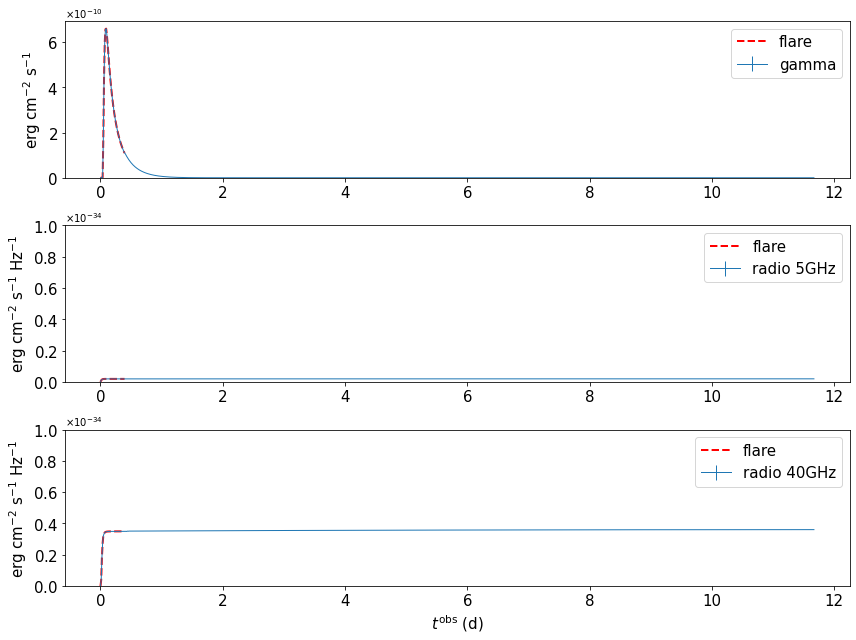

In [29]:
update_lc_plot(fig)


In [30]:
fig.savefig('temp_ev_sim_exp_vs_no_exp/lc_beta_exp_0.0.pdf',bbox_inches = 'tight',
    pad_inches = 0)

In [31]:
step=1
N=len(range(0,NUM_SET,step))
y_p_S_exp=np.zeros(N)
y_p_IC_exp=np.zeros(N)
y_p_S_no_exp=np.zeros(N)
y_p_IC_no_exp=np.zeros(N)
T_IC_dom=np.zeros(N)
for ID,i in enumerate(range(0,NUM_SET,step)):
    T_IC_dom[ID]=temp_ev_expansion.rad_region.time_sampled_emitters.time_obs[i]
    s_sync=temp_ev_expansion.rad_region.get_SED(comp='Sync',time_slice=i,frame='obs',use_cached=True)
    s_IC=temp_ev_expansion.rad_region.get_SED(comp='SSC',time_slice=i,frame='obs',use_cached=True)
    y_p_S_exp[ID]=s_sync.nuFnu.max().value
    y_p_IC_exp[ID]=s_IC.nuFnu.max().value
    
    s_sync=temp_ev_no_expansion.rad_region.get_SED(comp='Sync',time_slice=i,frame='obs',use_cached=True)
    s_IC=temp_ev_no_expansion.rad_region.get_SED(comp='SSC',time_slice=i,frame='obs',use_cached=True)
    y_p_S_no_exp[ID]=s_sync.nuFnu.max().value
    y_p_IC_no_exp[ID]=s_IC.nuFnu.max().value
    

In [32]:
t_exp_obs_CD=(t_exp*1.03)/temp_ev_expansion.rad_region.jet.parameters.beam_obj.val/86400

ticklabel_format failed


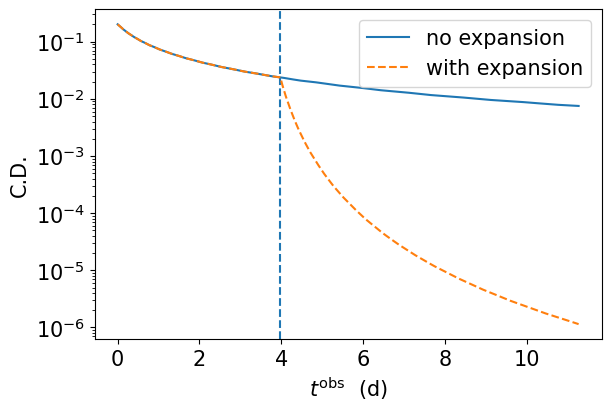

In [33]:
fig = plt.figure(constrained_layout=True,dpi=100)
ax=fig.add_subplot()
ax.axvline(x=t_exp_obs_CD,ls='--')
ax.semilogy(T_IC_dom/86400,y_p_IC_no_exp/y_p_S_no_exp,label='no expansion')
ax.semilogy(T_IC_dom/86400,y_p_IC_exp/y_p_S_exp,label='with expansion',ls='--')
ax.set_xlabel(r'$t^{\rm obs}$  (d)')
ax.set_ylabel('C.D.')
ax.legend(loc='best')
updage_fig(fig)

In [34]:
fig.savefig('temp_ev_sim_exp_vs_no_exp/CD_evolution.pdf',bbox_inches = 'tight',
    pad_inches = 0)

In [35]:
beta_exp=[0.1]
t_exp=0


for ID,v in enumerate(beta_exp):
    duration=delta_t_est(t_exp,R0,v)+10*t_dec_est(R0,-1,v)
    T_SIZE=np.int(duration/1000)
    NUM_SET=np.int(T_SIZE)
    NUM_SET=min(5000,NUM_SET)
    NUM_SET=max(200,NUM_SET)
    print('ID',ID)
    print('beta_exp %f'%v)
    print('delta_t  est. %e (d)'%(delta_t_est(t_exp,R0,v)/86400))
    print('t_dec  est. %e (d)'%(t_dec_est(R0,-1,v)/86400))
    print('delay  est. %e (s)'%(delta_t_est(t_exp,R0,v)))
    print('t_dec  est. %e (s)'%(t_dec_est(R0,-1,v)))
    print('duration %e'%duration)
    print('T_SIZE %d'%T_SIZE)
    print('NUM_SET %d'%NUM_SET)
    run_adiabatic_exp(None,
                      fit_model,
                      'temp_ev_sim_exp_beta_0.1_no_cooling',
                      temp_ev_acc_flare,
                      flare_duration=0,
                      average=None,
                      duration=duration,
                      delta_t_out=delta_t_out,
                      T_esc_rad=1E60,
                      rest_frame=rest_frame,
                      T_SIZE=T_SIZE,
                      NUM_SET=NUM_SET,
                      run=run,
                      beta_exp=v,
                      no_cooling=True,
                      t_exp=t_exp)
    
   
    print('---------------------------------------------')

ID 0
beta_exp 0.100000
delta_t  est. 1.929012e+01 (d)
t_dec  est. 1.929014e+01 (d)
delay  est. 1.666667e+06 (s)
t_dec  est. 1.666668e+06 (s)
duration 1.833334e+07
T_SIZE 18333
NUM_SET 5000
==> par: z_cosm from model: jet_leptonicacc_region linked to same parameter in model jet_leptonic
temporal evolution running


  0%|          | 0/18333 [00:00<?, ?it/s]

temporal evolution completed
caching SED for each saved distribution: start


  0%|          | 0/5000 [00:00<?, ?it/s]

caching SED for each saved distribution: done
1.0 1.0 18333343.333333332
t1=000 t2=000, t2_R=0.000e+00, R2=5.00000e+15 t/t_ref=0.000 t/t_exp=0.000 t/duration=0.000 1.00000e+00
t1=000 t2=555, t2_R=2.039e+06, R2=1.11129e+16 t/t_ref=2037038.037 t/t_exp=2037038.037 t/duration=0.111 1.00198e+00
t1=000 t2=1111, t2_R=4.078e+06, R2=1.72258e+16 t/t_ref=4074076.074 t/t_exp=4074076.074 t/duration=0.222 1.00255e+00
t1=000 t2=1666, t2_R=6.113e+06, R2=2.33267e+16 t/t_ref=6111114.111 t/t_exp=6111114.111 t/duration=0.333 1.00283e+00
t1=000 t2=2222, t2_R=8.151e+06, R2=2.94365e+16 t/t_ref=8148152.148 t/t_exp=8148152.148 t/duration=0.445 1.00299e+00
t1=000 t2=2777, t2_R=1.019e+07, R2=3.55374e+16 t/t_ref=10185190.185 t/t_exp=10185190.185 t/duration=0.556 1.00309e+00
t1=000 t2=3333, t2_R=1.223e+07, R2=4.16503e+16 t/t_ref=12222228.222 t/t_exp=12222228.222 t/duration=0.667 1.00317e+00
t1=000 t2=3888, t2_R=1.426e+07, R2=4.77512e+16 t/t_ref=14259266.259 t/t_exp=14259266.259 t/duration=0.778 1.00322e+00
t1=000 

In [36]:
beta_exp=[0.1]
t_exp=0


for ID,v in enumerate(beta_exp):
    duration=delta_t_est(t_exp,R0,v)+10*t_dec_est(R0,-1,v)
    T_SIZE=np.int(duration/1000)
    NUM_SET=np.int(T_SIZE)
    NUM_SET=min(5000,NUM_SET)
    NUM_SET=max(200,NUM_SET)
    print('ID',ID)
    print('beta_exp %f'%v)
    print('delta_t  est. %e (d)'%(delta_t_est(t_exp,R0,v)/86400))
    print('t_dec  est. %e (d)'%(t_dec_est(R0,-1,v)/86400))
    print('delay  est. %e (s)'%(delta_t_est(t_exp,R0,v)))
    print('t_dec  est. %e (s)'%(t_dec_est(R0,-1,v)))
    print('duration %e'%duration)
    print('T_SIZE %d'%T_SIZE)
    print('NUM_SET %d'%NUM_SET)
    run_adiabatic_exp(None,
                      fit_model,
                      'temp_ev_sim_exp_beta_0.1_no_sync_cooling',
                      temp_ev_acc_flare,
                      flare_duration=0,
                      average=None,
                      duration=duration,
                      delta_t_out=delta_t_out,
                      T_esc_rad=1E60,
                      rest_frame=rest_frame,
                      T_SIZE=T_SIZE,
                      NUM_SET=NUM_SET,
                      run=run,
                      beta_exp=v,
                      synch_cooling_off=True,
                      t_exp=t_exp)
    
   
    print('---------------------------------------------')

ID 0
beta_exp 0.100000
delta_t  est. 1.929012e+01 (d)
t_dec  est. 1.929014e+01 (d)
delay  est. 1.666667e+06 (s)
t_dec  est. 1.666668e+06 (s)
duration 1.833334e+07
T_SIZE 18333
NUM_SET 5000
==> par: z_cosm from model: jet_leptonicacc_region linked to same parameter in model jet_leptonic
temporal evolution running


  0%|          | 0/18333 [00:00<?, ?it/s]

temporal evolution completed
caching SED for each saved distribution: start


  0%|          | 0/5000 [00:00<?, ?it/s]

caching SED for each saved distribution: done
1.0 1.0 18333343.333333332
t1=000 t2=000, t2_R=0.000e+00, R2=5.00000e+15 t/t_ref=0.000 t/t_exp=0.000 t/duration=0.000 1.00000e+00
t1=000 t2=555, t2_R=2.039e+06, R2=1.11129e+16 t/t_ref=2037038.037 t/t_exp=2037038.037 t/duration=0.111 1.00198e+00
t1=000 t2=1111, t2_R=4.078e+06, R2=1.72258e+16 t/t_ref=4074076.074 t/t_exp=4074076.074 t/duration=0.222 1.00255e+00
t1=000 t2=1666, t2_R=6.113e+06, R2=2.33267e+16 t/t_ref=6111114.111 t/t_exp=6111114.111 t/duration=0.333 1.00268e+00
t1=000 t2=2222, t2_R=8.151e+06, R2=2.94365e+16 t/t_ref=8148152.148 t/t_exp=8148152.148 t/duration=0.445 1.00151e+00
t1=000 t2=2777, t2_R=1.019e+07, R2=3.55374e+16 t/t_ref=10185190.185 t/t_exp=10185190.185 t/duration=0.556 9.94654e-01
t1=000 t2=3333, t2_R=1.223e+07, R2=4.16503e+16 t/t_ref=12222228.222 t/t_exp=12222228.222 t/duration=0.667 9.74912e-01
t1=000 t2=3888, t2_R=1.426e+07, R2=4.77512e+16 t/t_ref=14259266.259 t/t_exp=14259266.259 t/duration=0.778 9.41392e-01
t1=000 